In [1]:
import numpy as np
import pandas as pd

import pymoo.gradient.toolbox as anp

from pymoo.core.problem import Problem
from pymoo.util.normalization import normalize
from pymoo.util.reference_direction import UniformReferenceDirectionFactory
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.util.remote import Remote

from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.selection.tournament import TournamentSelection

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.algorithms.moo.nsga2 import binary_tournament
from pymoo.algorithms.moo.nsga3 import comp_by_cv_then_random

from pymoo.util.display.column import Column
from pymoo.util.display.output import Output
from pymoo.util.display.display import Display

from pymoo.problems import get_problem

from pymoo.visualization.scatter import Scatter

from pymoo.optimize import minimize

from scipy.spatial import distance

import csv
import time

In [2]:
class measure_time(Output):
    def __init__(self):
        super().__init__()
        self.x_time = Column("x_time", width=13)
        self.columns += [self.x_time]

    def update(self, algorithm):
        super().update(algorithm)
        writer.writerow([time.time() - start_time])
        self.x_time.set(time.time() - start_time)

In [3]:
class DTLZ(Problem):
    def __init__(self, n_var, n_obj, k=None, **kwargs):

        if n_var:
            self.k = n_var - n_obj + 1
        elif k:
            self.k = k
            n_var = k + n_obj - 1
        else:
            raise Exception("Either provide number of variables or k!")

        super().__init__(n_var=n_var, n_obj=n_obj, xl=0, xu=1, vtype=float, **kwargs)

    def g1(self, X_M):
        return 100 * (self.k + anp.sum(anp.square(X_M - 0.5) - anp.cos(20 * anp.pi * (X_M - 0.5)), axis=1))

    def g2(self, X_M):
        return anp.sum(anp.square(X_M - 0.5), axis=1)

    def obj_func(self, X_, g, alpha=1):
        f = []

        for i in range(0, self.n_obj):
            _f = (1 + g)
            _f *= anp.prod(anp.cos(anp.power(X_[:, :X_.shape[1] - i], alpha) * anp.pi / 2.0), axis=1)
            if i > 0:
                _f *= anp.sin(anp.power(X_[:, X_.shape[1] - i], alpha) * anp.pi / 2.0)

            f.append(_f)

        f = anp.column_stack(f)
        return f

In [4]:
class DTLZ1(DTLZ):
    def __init__(self, n_var=3, n_obj=3, **kwargs):
        super().__init__(n_var=n_var, n_obj=n_obj, **kwargs)

    def _calc_pareto_front(self, ref_dirs=None):
        if ref_dirs is None:
            ref_dirs = get_ref_dirs(self.n_obj)
        return 0.5 * ref_dirs

    def obj_func(self, X_, g):
        f = []

        for i in range(0, self.n_obj):
            _f = 0.5 * (1 + g)
            _f *= anp.prod(X_[:, :X_.shape[1] - i], axis=1)
            if i > 0:
                _f *= 1 - X_[:, X_.shape[1] - i]
            f.append(_f)
        return anp.column_stack(f)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g1(X_M)
        out["F"] = self.obj_func(X_, g)

In [5]:
class DTLZ2(DTLZ):
    def __init__(self, n_var=10, n_obj=3, **kwargs):
        super().__init__(n_var=n_var, n_obj=n_obj, **kwargs)

    def _calc_pareto_front(self, ref_dirs=None):
        if ref_dirs is None:
            ref_dirs = get_ref_dirs(self.n_obj)
        return generic_sphere(ref_dirs)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g2(X_M)
        out["F"] = self.obj_func(X_, g, alpha=1)

In [6]:
class DTLZ3(DTLZ):
    def __init__(self, n_var=10, n_obj=3, **kwargs):
        super().__init__(n_var=n_var, n_obj=n_obj, **kwargs)

    def _calc_pareto_front(self, ref_dirs=None):
        if ref_dirs is None:
            ref_dirs = get_ref_dirs(self.n_obj)
        return generic_sphere(ref_dirs)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g1(X_M)
        out["F"] = self.obj_func(X_, g, alpha=1)

In [7]:
class DTLZ7(DTLZ):
    def __init__(self, n_var=10, n_obj=3, **kwargs):
        super().__init__(n_var=n_var, n_obj=n_obj, **kwargs)

    def _calc_pareto_front(self):
        if self.n_obj == 3:
            return Remote.get_instance().load("pymoo", "pf", "dtlz7-3d.pf")
        else:
            raise Exception("Not implemented yet.")

    def _evaluate(self, x, out, *args, **kwargs):
        f = []
        for i in range(0, self.n_obj - 1):
            f.append(x[:, i])
        f = anp.column_stack(f)

        g = 1 + 9 / self.k * anp.sum(x[:, -self.k:], axis=1)
        h = self.n_obj - anp.sum(f / (1 + g[:, None]) * (1 + anp.sin(3 * anp.pi * f)), axis=1)

        out["F"] = anp.column_stack([f, (1 + g) * h])

In [44]:
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

## DTLZ 1 

In [45]:
NOBJ = 3
NDIM = 4
P = 12

ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
MU=ref_dirs.shape[0]

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

In [46]:
problem = DTLZ1(n_var=NDIM, n_obj=NOBJ)

In [47]:
with open('pymoo_time_nsga2_dtlz1_92_500_3_4.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_dtlz1_92_500_3_4.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |       91 |  0.0151119232
     2 |      182 |  0.0345611572
     3 |      273 |  0.0483090878
     4 |      364 |  0.0582768917
     5 |      455 |  0.0682446957
     6 |      546 |  0.0772626400
     7 |      637 |  0.0837740898
     8 |      728 |  0.0917708874
     9 |      819 |  0.0997674465
    10 |      910 |  0.1077671051
    11 |     1001 |  0.1157686710
    12 |     1092 |  0.1197700500
    13 |     1183 |  0.1318037510
    14 |     1274 |  0.1358113289
    15 |     1365 |  0.1438088417
    16 |     1456 |  0.1517677307
    17 |     1547 |  0.1597671509
    18 |     1638 |  0.1677701473
    19 |     1729 |  0.1736798286
    20 |     1820 |  0.1816394329
    21 |     1911 |  0.1896727085
    22 |     2002 |  0.1936743259
    23 |     2093 |  0.2016303539
    24 |     2184 |  0.2096302509
    25 |     2275 |  0.2198848724
    26 |     2366 |  0.2278661728
    27 |     2457 |  0.2390401363
    28 |     2548 |  0.2510132790
    29 |     2

   262 |    23842 |  2.1715829372
   263 |    23933 |  2.1854748726
   264 |    24024 |  2.1914980412
   265 |    24115 |  2.1994161606
   266 |    24206 |  2.2063977718
   267 |    24297 |  2.2123467922
   268 |    24388 |  2.2194273472
   269 |    24479 |  2.2274301052
   270 |    24570 |  2.2313883305
   271 |    24661 |  2.2394306660
   272 |    24752 |  2.2473909855
   273 |    24843 |  2.2554352283
   274 |    24934 |  2.2633898258
   275 |    25025 |  2.2713890076
   276 |    25116 |  2.2856888771
   277 |    25207 |  2.2896907330
   278 |    25298 |  2.2976872921
   279 |    25389 |  2.3017299175
   280 |    25480 |  2.3096873760
   281 |    25571 |  2.3177275658
   282 |    25662 |  2.3296873569
   283 |    25753 |  2.3377292156
   284 |    25844 |  2.3416869640
   285 |    25935 |  2.3496892452
   286 |    26026 |  2.3576869965
   287 |    26117 |  2.3656885624
   288 |    26208 |  2.3696901798
   289 |    26299 |  2.3780388832
   290 |    26390 |  2.3911821842
   291 |    26

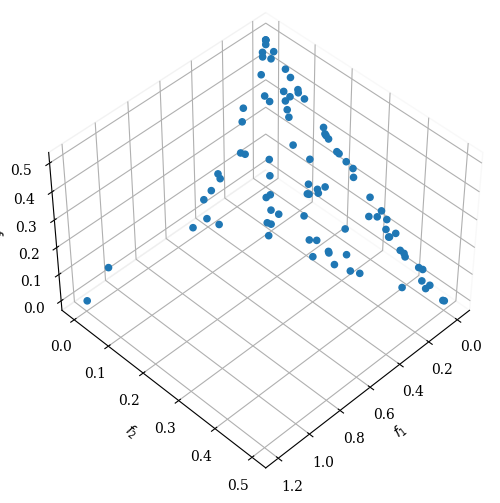

In [15]:
Scatter().add(res.F).show()

In [ ]:
PCP().add(res.F).show()

In [48]:
with open('pymoo_time_nsga3_dtlz1_92_500_3_4.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_dtlz1_92_500_3_4.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |       91 |  0.0095837116
     2 |      182 |  0.0233883858
     3 |      273 |  0.0343604088
     4 |      364 |  0.0463314056
     5 |      455 |  0.0612347126
     6 |      546 |  0.0719759464
     7 |      637 |  0.0809521675
     8 |      728 |  0.0930883884
     9 |      819 |  0.1010422707
    10 |      910 |  0.1130425930
    11 |     1001 |  0.1250448227
    12 |     1092 |  0.1370453835
    13 |     1183 |  0.1450464725
    14 |     1274 |  0.1683986187
    15 |     1365 |  0.1836628914
    16 |     1456 |  0.1960792542
    17 |     1547 |  0.2053079605
    18 |     1638 |  0.2165644169
    19 |     1729 |  0.2316732407
    20 |     1820 |  0.2437777519
    21 |     1911 |  0.2587363720
    22 |     2002 |  0.2740190029
    23 |     2093 |  0.2880792618
    24 |     2184 |  0.2995035648
    25 |     2275 |  0.3097512722
    26 |     2366 |  0.3194682598
    27 |     2457 |  0.3395750523
    28 |     2548 |  0.3497686386
    29 |     2

   243 |    22113 |  3.3296396732
   244 |    22204 |  3.3574984074
   245 |    22295 |  3.3737127781
   246 |    22386 |  3.3935754299
   247 |    22477 |  3.4176912308
   248 |    22568 |  3.4357347488
   249 |    22659 |  3.4473066330
   250 |    22750 |  3.4593069553
   251 |    22841 |  3.4713065624
   252 |    22932 |  3.4793059826
   253 |    23023 |  3.4953081608
   254 |    23114 |  3.5056984425
   255 |    23205 |  3.5176978111
   256 |    23296 |  3.5296978951
   257 |    23387 |  3.5466058254
   258 |    23478 |  3.5615437031
   259 |    23569 |  3.5734069347
   260 |    23660 |  3.5833795071
   261 |    23751 |  3.5935001373
   262 |    23842 |  3.6111817360
   263 |    23933 |  3.6245641708
   264 |    24024 |  3.6354990005
   265 |    24115 |  3.6478781700
   266 |    24206 |  3.6619431973
   267 |    24297 |  3.6739056110
   268 |    24388 |  3.6819050312
   269 |    24479 |  3.6939053535
   270 |    24570 |  3.7059051991
   271 |    24661 |  3.7179059982
   272 |    24

   490 |    44590 |  6.5854592323
   491 |    44681 |  6.6034147739
   492 |    44772 |  6.6144230366
   493 |    44863 |  6.6263492107
   494 |    44954 |  6.6413128376
   495 |    45045 |  6.6572685242
   496 |    45136 |  6.6672399044
   497 |    45227 |  6.6812038422
   498 |    45318 |  6.6981575489
   499 |    45409 |  6.7101264000
   500 |    45500 |  6.7240886688


In [18]:
res.X[50]

array([0.99999949, 0.41661999, 0.50001196, 0.49999905])

## DTLZ 2

In [49]:
NOBJ = 4
NDIM = 5
P = 7

ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
MU=ref_dirs.shape[0]

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

In [50]:
problem = DTLZ2(n_var=NDIM, n_obj=NOBJ)

In [51]:
with open('pymoo_time_nsga3_dtlz2_120_500_4_5.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_dtlz2_120_500_4_5.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3","f4"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      120 |  0.0169546604
     2 |      240 |  0.0398943424
     3 |      360 |  0.0588819981
     4 |      480 |  0.0748438835
     5 |      600 |  0.0927526951
     6 |      720 |  0.1097068787
     7 |      840 |  0.1267037392
     8 |      960 |  0.1426563263
     9 |     1080 |  0.1605687141
    10 |     1200 |  0.1765279770
    11 |     1320 |  0.1955194473
    12 |     1440 |  0.2114741802
    13 |     1560 |  0.2303853035
    14 |     1680 |  0.2573106289
    15 |     1800 |  0.2772967815
    16 |     1920 |  0.2991998196
    17 |     2040 |  0.3171496391
    18 |     2160 |  0.3331072330
    19 |     2280 |  0.3511002064
    20 |     2400 |  0.3680155277
    21 |     2520 |  0.3859658241
    22 |     2640 |  0.4029221535
    23 |     2760 |  0.4238650799
    24 |     2880 |  0.4478023052
    25 |     3000 |  0.4677472115
    26 |     3120 |  0.4916834831
    27 |     3240 |  0.5136253834
    28 |     3360 |  0.5335714817
    29 |     3

   239 |    28680 |  4.6113936901
   240 |    28800 |  4.6322999001
   241 |    28920 |  4.6512882710
   242 |    29040 |  4.6672453880
   243 |    29160 |  4.6861939430
   244 |    29280 |  4.7021508217
   245 |    29400 |  4.7210643291
   246 |    29520 |  4.7380175591
   247 |    29640 |  4.7559690475
   248 |    29760 |  4.7729647160
   249 |    29880 |  4.7919116020
   250 |    30000 |  4.8088717461
   251 |    30120 |  4.8297724724
   252 |    30240 |  4.8517127037
   253 |    30360 |  4.8676707745
   254 |    30480 |  4.8856601715
   255 |    30600 |  4.9025785923
   256 |    30720 |  4.9205701351
   257 |    30840 |  4.9374833107
   258 |    30960 |  4.9554355145
   259 |    31080 |  4.9733889103
   260 |    31200 |  4.9913413525
   261 |    31320 |  5.0082943439
   262 |    31440 |  5.0252869129
   263 |    31560 |  5.0461933613
   264 |    31680 |  5.0651443005
   265 |    31800 |  5.0850884914
   266 |    31920 |  5.1020448208
   267 |    32040 |  5.1219894886
   268 |    32

   484 |    58080 |  9.2601566315
   485 |    58200 |  9.2878355980
   486 |    58320 |  9.3084697723
   487 |    58440 |  9.3235907555
   488 |    58560 |  9.3415906429
   489 |    58680 |  9.3596282005
   490 |    58800 |  9.3844099045
   491 |    58920 |  9.4035925865
   492 |    59040 |  9.4168276787
   493 |    59160 |  9.4360187054
   494 |    59280 |  9.4540176392
   495 |    59400 |  9.4792151451
   496 |    59520 |  9.5007183552
   497 |    59640 |  9.5236599445
   498 |    59760 |  9.5366814137
   499 |    59880 |  9.5559124947
   500 |    60000 |  9.5738272667


In [52]:
with open('pymoo_time_nsga2_dtlz2_120_500_4_5.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_dtlz2_120_500_4_5.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3","f4"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      120 |  0.0080463886
     2 |      240 |  0.0224003792
     3 |      360 |  0.0324397087
     4 |      480 |  0.0414152145
     5 |      600 |  0.0551214218
     6 |      720 |  0.0647022724
     7 |      840 |  0.0717871189
     8 |      960 |  0.0837843418
     9 |     1080 |  0.0968701839
    10 |     1200 |  0.1117627621
    11 |     1320 |  0.1285741329
    12 |     1440 |  0.1405367851
    13 |     1560 |  0.1534986496
    14 |     1680 |  0.1649246216
    15 |     1800 |  0.1739037037
    16 |     1920 |  0.1856696606
    17 |     2040 |  0.2689046860
    18 |     2160 |  0.2878689766
    19 |     2280 |  0.2999000549
    20 |     2400 |  0.3152523041
    21 |     2520 |  0.3351991177
    22 |     2640 |  0.3497624397
    23 |     2760 |  0.3587398529
    24 |     2880 |  0.3717048168
    25 |     3000 |  0.3897879124
    26 |     3120 |  0.3998692036
    27 |     3240 |  0.4048895836
    28 |     3360 |  0.4149363041
    29 |     3

   256 |    30720 |  2.8697590828
   257 |    30840 |  2.8852045536
   258 |    30960 |  2.8950295448
   259 |    31080 |  2.9040427208
   260 |    31200 |  2.9184191227
   261 |    31320 |  2.9265272617
   262 |    31440 |  2.9351248741
   263 |    31560 |  2.9447216988
   264 |    31680 |  2.9551954269
   265 |    31800 |  2.9665412903
   266 |    31920 |  2.9746110439
   267 |    32040 |  2.9905388355
   268 |    32160 |  3.0025408268
   269 |    32280 |  3.0155894756
   270 |    32400 |  3.0236210823
   271 |    32520 |  3.0315849781
   272 |    32640 |  3.0395846367
   273 |    32760 |  3.0515811443
   274 |    32880 |  3.0595812798
   275 |    33000 |  3.0675816536
   276 |    33120 |  3.0839915276
   277 |    33240 |  3.0950045586
   278 |    33360 |  3.1040203571
   279 |    33480 |  3.1148588657
   280 |    33600 |  3.1228370667
   281 |    33720 |  3.1289026737
   282 |    33840 |  3.1409423351
   283 |    33960 |  3.1489460468
   284 |    34080 |  3.1569027901
   285 |    34

## DTLZ 3

In [53]:
NOBJ = 6
NDIM = 6
P = 5

ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
MU=ref_dirs.shape[0]

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

In [54]:
problem = DTLZ3(n_var=NDIM, n_obj=NOBJ)

In [55]:
MU

252

In [56]:
with open('pymoo_time_nsga3_dtlz3_252_500_6_6.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_dtlz3_252_500_6_6.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3","f4","f5","f6"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      252 |  0.0430462360
     2 |      504 |  0.0971291065
     3 |      756 |  0.1634771824
     4 |     1008 |  0.2237303257
     5 |     1260 |  0.2793867588
     6 |     1512 |  0.3416662216
     7 |     1764 |  0.3970444202
     8 |     2016 |  0.4410815239
     9 |     2268 |  0.4931616783
    10 |     2520 |  0.5469219685
    11 |     2772 |  0.6131591797
    12 |     3024 |  0.6971385479
    13 |     3276 |  0.7610397339
    14 |     3528 |  0.8410499096
    15 |     3780 |  0.9144749641
    16 |     4032 |  0.9814200401
    17 |     4284 |  1.0414204597
    18 |     4536 |  1.1168820858
    19 |     4788 |  1.2232747078
    20 |     5040 |  1.2809982300
    21 |     5292 |  1.3449604511
    22 |     5544 |  1.4051520824
    23 |     5796 |  1.4833288193
    24 |     6048 |  1.5449764729
    25 |     6300 |  1.6131460667
    26 |     6552 |  1.6732280254
    27 |     6804 |  1.7464373112
    28 |     7056 |  1.8113265038
    29 |     7

   242 |    60984 |  1.646631E+01
   243 |    61236 |  1.653612E+01
   244 |    61488 |  1.659895E+01
   245 |    61740 |  1.666087E+01
   246 |    61992 |  1.672665E+01
   247 |    62244 |  1.679252E+01
   248 |    62496 |  1.685734E+01
   249 |    62748 |  1.699194E+01
   250 |    63000 |  1.706275E+01
   251 |    63252 |  1.712662E+01
   252 |    63504 |  1.718842E+01
   253 |    63756 |  1.725424E+01
   254 |    64008 |  1.731563E+01
   255 |    64260 |  1.737820E+01
   256 |    64512 |  1.744007E+01
   257 |    64764 |  1.750490E+01
   258 |    65016 |  1.756869E+01
   259 |    65268 |  1.763052E+01
   260 |    65520 |  1.769339E+01
   261 |    65772 |  1.776217E+01
   262 |    66024 |  1.782800E+01
   263 |    66276 |  1.789186E+01
   264 |    66528 |  1.795466E+01
   265 |    66780 |  1.802654E+01
   266 |    67032 |  1.809137E+01
   267 |    67284 |  1.815620E+01
   268 |    67536 |  1.821508E+01
   269 |    67788 |  1.828231E+01
   270 |    68040 |  1.834910E+01
   271 |    68

   483 |   121716 |  3.367200E+01
   484 |   121968 |  3.374365E+01
   485 |   122220 |  3.383698E+01
   486 |   122472 |  3.390917E+01
   487 |   122724 |  3.397317E+01
   488 |   122976 |  3.404121E+01
   489 |   123228 |  3.410517E+01
   490 |   123480 |  3.416917E+01
   491 |   123732 |  3.423321E+01
   492 |   123984 |  3.429717E+01
   493 |   124236 |  3.435720E+01
   494 |   124488 |  3.442517E+01
   495 |   124740 |  3.448920E+01
   496 |   124992 |  3.454920E+01
   497 |   125244 |  3.461320E+01
   498 |   125496 |  3.468246E+01
   499 |   125748 |  3.474643E+01
   500 |   126000 |  3.481094E+01


In [57]:
with open('pymoo_time_nsga2_dtlz3_252_500_6_6.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_dtlz3_252_500_6_6.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3","f4","f5","f6"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      252 |  0.0160017014
     2 |      504 |  0.0440013409
     3 |      756 |  0.0653834343
     4 |     1008 |  0.0855295658
     5 |     1260 |  0.1094939709
     6 |     1512 |  0.1494932175
     7 |     1764 |  0.1820633411
     8 |     2016 |  0.2060666084
     9 |     2268 |  0.2311291695
    10 |     2520 |  0.2529175282
    11 |     2772 |  0.2778646946
    12 |     3024 |  0.3018605709
    13 |     3276 |  0.3218584061
    14 |     3528 |  0.3458194733
    15 |     3780 |  0.3660557270
    16 |     4032 |  0.3940920830
    17 |     4284 |  0.4180953503
    18 |     4536 |  0.4380538464
    19 |     4788 |  0.4699435234
    20 |     5040 |  0.4939427376
    21 |     5292 |  0.5179426670
    22 |     5544 |  0.5419397354
    23 |     5796 |  0.5619430542
    24 |     6048 |  0.5819423199
    25 |     6300 |  0.6059768200
    26 |     6552 |  0.6259486675
    27 |     6804 |  0.6478612423
    28 |     7056 |  0.6742413044
    29 |     7

   244 |    61488 |  5.9536290169
   245 |    61740 |  5.9816348553
   246 |    61992 |  6.0016369820
   247 |    62244 |  6.0216357708
   248 |    62496 |  6.0456357002
   249 |    62748 |  6.1177477837
   250 |    63000 |  6.1377856731
   251 |    63252 |  6.1617472172
   252 |    63504 |  6.1857171059
   253 |    63756 |  6.2057530880
   254 |    64008 |  6.2257196903
   255 |    64260 |  6.2457175255
   256 |    64512 |  6.2697196007
   257 |    64764 |  6.2882242203
   258 |    65016 |  6.3122260571
   259 |    65268 |  6.3322644234
   260 |    65520 |  6.3522288799
   261 |    65772 |  6.3722977638
   262 |    66024 |  6.3937103748
   263 |    66276 |  6.4137091637
   264 |    66528 |  6.4376695156
   265 |    66780 |  6.4576683044
   266 |    67032 |  6.4778575897
   267 |    67284 |  6.4978845119
   268 |    67536 |  6.5218868256
   269 |    67788 |  6.5378856659
   270 |    68040 |  6.5618844032
   271 |    68292 |  6.5817511082
   272 |    68544 |  6.6017105579
   273 |    68

   489 |   123228 |  1.133209E+01
   490 |   123480 |  1.135609E+01
   491 |   123732 |  1.137609E+01
   492 |   123984 |  1.139610E+01
   493 |   124236 |  1.141610E+01
   494 |   124488 |  1.144810E+01
   495 |   124740 |  1.146810E+01
   496 |   124992 |  1.149231E+01
   497 |   125244 |  1.151231E+01
   498 |   125496 |  1.153235E+01
   499 |   125748 |  1.155631E+01
   500 |   126000 |  1.157631E+01


## DTLZ 7

In [58]:
NOBJ = 3
NDIM = 10
P = 12

ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
MU=ref_dirs.shape[0]

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

In [59]:
problem = DTLZ7(n_var=NDIM, n_obj=NOBJ)

In [60]:
MU

91

In [61]:
with open('pymoo_time_nsga3_dtlz7_92_500_3_10.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_dtlz7_92_500_3_10.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |       91 |  0.0080046654
     2 |      182 |  0.0200424194
     3 |      273 |  0.0280039310
     4 |      364 |  0.0400075912
     5 |      455 |  0.0480430126
     6 |      546 |  0.0600090027
     7 |      637 |  0.0720071793
     8 |      728 |  0.0800077915
     9 |      819 |  0.0920045376
    10 |      910 |  0.1014580727
    11 |     1001 |  0.1134512424
    12 |     1092 |  0.1214518547
    13 |     1183 |  0.1334884167
    14 |     1274 |  0.1414496899
    15 |     1365 |  0.1534488201
    16 |     1456 |  0.1654484272
    17 |     1547 |  0.1734497547
    18 |     1638 |  0.1854865551
    19 |     1729 |  0.1974492073
    20 |     1820 |  0.2054884434
    21 |     1911 |  0.2174866199
    22 |     2002 |  0.2294514179
    23 |     2093 |  0.2414512634
    24 |     2184 |  0.2534871101
    25 |     2275 |  0.2647745609
    26 |     2366 |  0.2767684460
    27 |     2457 |  0.2848031521
    28 |     2548 |  0.3007371426
    29 |     2

   249 |    22659 |  3.0219979286
   250 |    22750 |  3.0339608192
   251 |    22841 |  3.0459589958
   252 |    22932 |  3.0579600334
   253 |    23023 |  3.0700864792
   254 |    23114 |  3.0820467472
   255 |    23205 |  3.0940909386
   256 |    23296 |  3.1021134853
   257 |    23387 |  3.1142137051
   258 |    23478 |  3.1262161732
   259 |    23569 |  3.1382536888
   260 |    23660 |  3.1502809525
   261 |    23751 |  3.1622192860
   262 |    23842 |  3.1742517948
   263 |    23933 |  3.1862521172
   264 |    24024 |  3.1982517242
   265 |    24115 |  3.2113134861
   266 |    24206 |  3.2193689346
   267 |    24297 |  3.2353410721
   268 |    24388 |  3.2473020554
   269 |    24479 |  3.2593040466
   270 |    24570 |  3.2713053226
   271 |    24661 |  3.2833406925
   272 |    24752 |  3.2953398228
   273 |    24843 |  3.3063580990
   274 |    24934 |  3.3183484077
   275 |    25025 |  3.3303465843
   276 |    25116 |  3.3423476219
   277 |    25207 |  3.3543465137
   278 |    25

In [62]:
with open('pymoo_time_nsga2_dtlz7_220_500_3_10.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_dtlz7_220_500_3_10.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |       91 |  0.0039999485
     2 |      182 |  0.0160360336
     3 |      273 |  0.0239977837
     4 |      364 |  0.0320391655
     5 |      455 |  0.0360395908
     6 |      546 |  0.0440013409
     7 |      637 |  0.0520000458
     8 |      728 |  0.0599987507
     9 |      819 |  0.0679981709
    10 |      910 |  0.0760366917
    11 |     1001 |  0.0838000774
    12 |     1092 |  0.0917994976
    13 |     1183 |  0.0998499393
    14 |     1274 |  0.1118028164
    15 |     1365 |  0.1198036671
    16 |     1456 |  0.1278004646
    17 |     1547 |  0.1358039379
    18 |     1638 |  0.1398029327
    19 |     1729 |  0.1518003941
    20 |     1820 |  0.1598007679
    21 |     1911 |  0.1678035259
    22 |     2002 |  0.1718020439
    23 |     2093 |  0.1798028946
    24 |     2184 |  0.1878020763
    25 |     2275 |  0.1958041191
    26 |     2366 |  0.2038400173
    27 |     2457 |  0.2118043900
    28 |     2548 |  0.2198007107
    29 |     2

   253 |    23023 |  1.9458870888
   254 |    23114 |  1.9538860321
   255 |    23205 |  1.9618878365
   256 |    23296 |  1.9698879719
   257 |    23387 |  1.9778890610
   258 |    23478 |  1.9864397049
   259 |    23569 |  1.9944369793
   260 |    23660 |  2.0024745464
   261 |    23751 |  2.0064783096
   262 |    23842 |  2.0144402981
   263 |    23933 |  2.0224380493
   264 |    24024 |  2.0304384232
   265 |    24115 |  2.0384397507
   266 |    24206 |  2.0464363098
   267 |    24297 |  2.0504353046
   268 |    24388 |  2.0639064312
   269 |    24479 |  2.0698893070
   270 |    24570 |  2.0776851177
   271 |    24661 |  2.0836672783
   272 |    24752 |  2.0906510353
   273 |    24843 |  2.0987656116
   274 |    24934 |  2.1067616940
   275 |    25025 |  2.1107625961
   276 |    25116 |  2.1187644005
   277 |    25207 |  2.1267225742
   278 |    25298 |  2.1347253323
   279 |    25389 |  2.1427247524
   280 |    25480 |  2.1467256546
   281 |    25571 |  2.1547613144
   282 |    25